# Ensemble Evaluation: Timepoint 3 - Winter 2022 

Location: New York State

Timepoint 3: January 4, 2022. Setting: New York State coinciding with the arrival of the first Omicron wave. At-home testing widely available.

Using wastewater data to calibrate models.

### Load dependencies

In [16]:
import os
import pandas as pd
import numpy as np
import math
import copy
from datetime import datetime
from pyciemss.Ensemble.interfaces import (
    load_and_sample_petri_ensemble, load_and_calibrate_and_sample_ensemble_model
)
from pyciemss.PetriNetODE.interfaces import (
    load_and_sample_petri_model,
    load_and_calibrate_and_sample_petri_model,
    load_and_optimize_and_sample_petri_model,
    load_and_calibrate_and_optimize_and_sample_petri_model
)
from pyciemss.visuals import plots
from pyciemss.utils import get_tspan
from pyciemss.utils.interface_utils import cdc_reformatcsv

## Get and process wastewater data

In [2]:
url = 'https://raw.githubusercontent.com/DARPA-ASKEM/experiments/main/thin-thread-examples/milestone_12month/evaluation/ensemble_eval_SA/datasets/4f93bb09-1faf-4760-be3e-f865ab0cc946/SARS-CoV-2_concentrations_measured_in_NYC_Wastewater%20(1).csv'
ww_data1 = pd.read_csv(url)
ww_data1 = ww_data1[["Sample Date", "WRRF Name", "Concentration SARS-CoV-2 gene target (N1 Copies/L) "]]
# ww_data1

In [3]:
# Flow rates in million gallons per day for New York Wastewater Resource Recovery Facilities, taken from: https://doi.org/10.1039/D1EW00747E 
ww_flow_rate_dict = {"Hunts Point": 136, 
                    "Wards Island": 180,
                    "North River": 94,
                    "Newtown Creek": 188,
                    "Red Hook": 26,
                    "Owls Head": 95,
                    "Coney Island": 82,
                    "26th Ward": 55,
                    "Rockaway": 20,
                    "Jamaica Bay": 81,
                    "Tallman Island": 59,
                    "Bowery Bay": 100,
                    "Port Richmond": 29,
                    "Oakwood Beach": 28
                    }

total_pop_included_in_data = 755948 + 1201485 + 658596 + 1156473 + 224029 + 906442 + 682342 + 290608 + 120539 + 748737 + 449907 + 924695 + 226167 + 258731
pop_scale_factor = round(19340000/total_pop_included_in_data) # to scale the data from NYC to NYS

In [4]:
ww_data_dict = {}
for i in range(len(ww_data1)):
    if math.isnan(ww_data1.iloc[i]["Concentration SARS-CoV-2 gene target (N1 Copies/L) "]):
        ww_data_dict[i] = [ww_data1.iloc[i]["Sample Date"], 0]
    else:
        ww_data_dict[i] = [ww_data1.iloc[i]["Sample Date"], 1000000*3.78541*ww_flow_rate_dict[ww_data1.iloc[i]["WRRF Name"]]*ww_data1.iloc[i]["Concentration SARS-CoV-2 gene target (N1 Copies/L) "]]

# Compile the data into a DataFrame
ww_data2 = pd.DataFrame.from_dict(ww_data_dict, orient='index', columns=["date", "V"])
ww_data2['date'] = pd.to_datetime(ww_data2.date)
ww_data2.sort_values(by='date', ascending = True, inplace = True)
ww_data2 = ww_data2.reset_index(drop=True)
ww_data2 = ww_data2.groupby("date")["V"].sum()
ww_data2 = pd.DataFrame({"V": ww_data2})
ww_data2 = ww_data2.reset_index()

# Calculate the timepoint to use because of missing data
year = pd.Series([2020 for i in range(len(ww_data2))])
month = pd.Series([8 for i in range(len(ww_data2))])
day = pd.Series([31 for i in range(len(ww_data2))])
s = pd.to_datetime(pd.DataFrame({'year':year, 'month':month, 'day':day})).dt.date
s = s.to_frame("date")
s["date"] = pd.to_datetime(s.date)
ww_data2["timepoints"] = (ww_data2["date"] - s["date"]).dt.days

# Calculate the cumulative sum and scale appropriately for NYS population
ww_data3 = ww_data2[["V"]].copy()
ww_data3 = ww_data3.cumsum()
ww_data4 = ww_data3[["V"]].mul(pop_scale_factor)
ww_data4 = ww_data4.assign(timepoints=ww_data2["timepoints"])

# Test data contains all of the data, indexed by days since 08/31/2020
test_data = ww_data4[74:128].set_index(["timepoints"])

ww_data4 = ww_data4[["timepoints", "V"]]
ww_data4 = ww_data4[74:119] # for calibration, use data from 06/27/2021 to 01/02/2022
ww_data2.to_csv("../../notebook/ensemble_eval_sa/datasets/nys_ww_data_date_key.csv", index=False) # do not use this as data for calibration, only for matching dates with timepoints
ww_data4.to_csv("../../notebook/ensemble_eval_sa/datasets/nys_ww_data.csv", index=False)

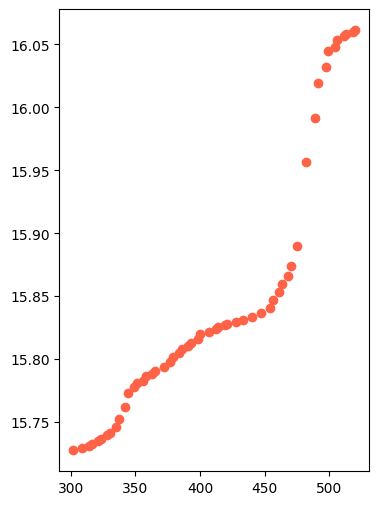

In [5]:
# Plot the data
import matplotlib.pyplot as plt
plt.figure(figsize=(4,6))
plt.scatter(test_data.index, np.log10(test_data.V), color='tomato')

## Set up timepoints

In [6]:
start_timepoint = 300
stop_timepoint = 520 # simulate for four weeks after end of data
timepoints = [float(i) for i in range(stop_timepoint + 1)]
timepoints = timepoints[300:521]

In [7]:
(total_pop_included_in_data)*9.06e-8

0.7795857294

## SEIV model

In [8]:
import sympy
import itertools

from mira.metamodel import *
from mira.modeling import Model
from mira.modeling.askenet.petrinet import AskeNetPetriNetModel

person_units = lambda: Unit(expression=sympy.Symbol('person'))
virus_units = lambda: Unit(expression=sympy.Symbol('virus'))
virus_per_gram_units = lambda: Unit(expression=sympy.Symbol('virus')/sympy.Symbol('gram'))
day_units = lambda: Unit(expression=sympy.Symbol('day'))
per_day_units = lambda: Unit(expression=1/sympy.Symbol('day'))
dimensionless_units = lambda: Unit(expression=sympy.Integer('1'))
gram_units = lambda: Unit(expression=sympy.Symbol('gram'))
per_day_per_person_units = lambda: Unit(expression=1/(sympy.Symbol('day')*sympy.Symbol('person')))

# See Table 1 of the paper
c = {
    'S': Concept(name='S', units=person_units(), identifiers={'ido': '0000514'}),
    'E': Concept(name='E', units=person_units(), identifiers={'apollosv': '0000154'}),
    'I': Concept(name='I', units=person_units(), identifiers={'ido': '0000511'}),
    'V': Concept(name='V', units=person_units(), identifiers={'vido': '0001331'}),
}


parameters = {
    'gamma': Parameter(name='gamma', value=0.08, units=per_day_units()),
    'delta': Parameter(name='delta', value=1/8, units=per_day_units()),
    'alpha': Parameter(name='alpha', value=500, units=gram_units(),
                       distribution=Distribution(type='Uniform1',
                                                 parameters={
                                                     'minimum': 51,
                                                     'maximum': 796
                                                 })),
    'lambda': Parameter(name='lambda', value=0.005, 
                            distribution=Distribution(type='Uniform1',
                                                      parameters={
                                                          'minimum': 9e-08,
                                                          'maximum': 0.8
                                                      }),
                        units=per_day_per_person_units()),
    'beta': Parameter(name='beta', value=4.49e7, units=virus_per_gram_units()),
    'k': Parameter(name='k', value=1/3, units=per_day_units()),
}

initials = {
    'S': Initial(concept=Concept(name='S'), value=19339950.0),
    'E': Initial(concept=Concept(name='E'), value=50.0),
    'I': Initial(concept=Concept(name='I'), value=0.0),
    'V': Initial(concept=Concept(name='V'), value=(5980000000000000.0 / 4)),
}

# initials = {
#     'S': Initial(concept=Concept(name='S'), value=19329000.0),
#     'E': Initial(concept=Concept(name='E'), value=10000.0),
#     'I': Initial(concept=Concept(name='I'), value=1000.0),
#     'V': Initial(concept=Concept(name='V'), value=10000000000000.0),
# }

S, E, I, V, gamma, delta, alpha, lmbd, beta, k = \
    sympy.symbols('S E I V gamma delta alpha lambda beta k')

t1 = ControlledConversion(subject=c['S'],
                          outcome=c['E'],
                          controller=c['I'],
                          rate_law=S*I*lmbd/(S+I+E))
t2 = NaturalConversion(subject=c['E'],
                       outcome=c['I'],
                       rate_law=k*E)
t3 = NaturalDegradation(subject=c['I'],
                        rate_law=delta*I)
t4 = ControlledProduction(outcome=c['V'],
                          controller=c['I'],
                          rate_law=alpha*beta*(1-gamma)*I)
templates = [t1, t2, t3, t4]
observables = {}
SEIV = TemplateModel(
    templates=templates,
    parameters=parameters,
    initials=initials,
    time=Time(name='t', units=day_units()),
    observables=observables,
    annotations=Annotations(name='Scenario 3 base model'))

In [ ]:
        {
          "id": "logV",
          "name": "logV",
            "expression": "log(V)*0.43429448190325176",
          "expression_mathml": "<apply><divide/><apply><ln/><ci>V</ci></apply><apply><ln/><cn>10</cn></apply></apply>"
        }

### Plot prior viral load against measured viral load

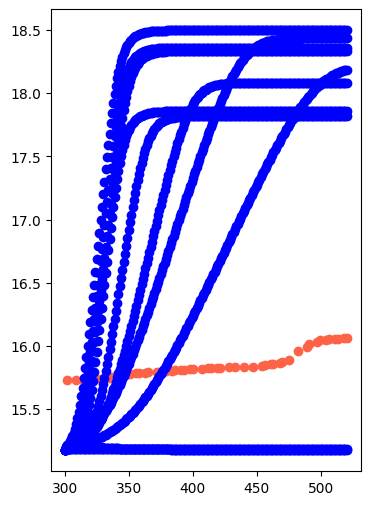

In [9]:
num_samples = 10
# start_time = 300
# end_time = 520 # sample from 06/27/2021 (DAY 0) through the end of the forecast 02/02/2022 (DAY 520)
# num_timepoints = (end_time-start_time)*10 + 1

# timepoints = list(get_tspan(start_time, end_time, num_timepoints).detach().numpy())

prior_samples = load_and_sample_petri_model(SEIV, num_samples, timepoints=timepoints, method="euler",
                                            visual_options={"title": "3_base", "keep":["I_sol", "E_sol", "V_sol"]}, 
                                            time_unit="days")
#display(prior_samples)

# schema = plots.trajectories(pd.DataFrame(prior_samples["data"]), keep="V_sol",
#                             points=test_data[0:120].reset_index(drop=True).rename(columns={"V":"V_data"}))
# schema = plots.pad(schema, 5)
# plots.ipy_display(schema)

# Plot cumulative viral load data and prior samples
plt.figure(figsize=(4,6))
plt.scatter(test_data.index, np.log10(test_data.V), color='tomato')
plt.scatter(prior_samples["data"]["timepoint_days"], np.log10(prior_samples["data"]["V_sol"]), color="blue")

### Plot all other priors

In [10]:
schema = plots.trajectories(prior_samples["data"].drop(columns='V_sol'), keep=".*_sol",
                            #points=ww_data_train.reset_index(drop=True).rename(columns={"V":"V_data"})
                                        )
schema = plots.pad(schema, 5)
plots.ipy_display(schema)

### Calibrate

iteration 0: loss = 4088.495488896966
iteration 25: loss = 4061.993440285325


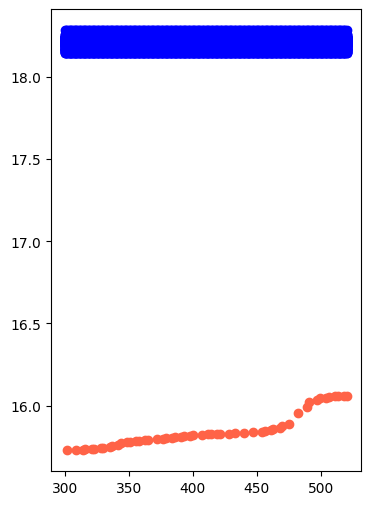

In [12]:
# start_time = 300
# end_time = 520 # sample from 06/27/2021 (DAY 0) through the end of the forecast 02/02/2022 (DAY 520)
# num_timepoints = (end_time-start_time)*10 + 1

# timepoints = list(get_tspan(start_time, end_time, num_timepoints).detach().numpy())

# post_samples = load_and_calibrate_and_sample_petri_model(
#     SEIV,
#     'nys_ww_data.csv',
#     num_samples,
#     num_iterations=300,
#     timepoints=timepoints,
#     verbose=True,
#     noise_scale=1.,
#     method="dopri5", time_unit="days")

# display(post_samples['data'])

# # Plot calibrated samples with data
# plt.figure(figsize=(4,6))
# plt.scatter(test_data.index, np.log10(test_data.V), color='tomato')
# plt.scatter(post_samples["data"]["timepoint_days"], np.log10(post_samples["data"]["V_sol"]), color="blue")

num_samples = 100
model_paths = [SEIV]
data_path = "../../notebook/ensemble_eval_sa/datasets/nys_ww_data.csv"
weights = [1]
solution_mappings = [{"V": "V"}] # "column name in data": "observable or state variable in model"

# Run the calibration and sampling
result = load_and_calibrate_and_sample_ensemble_model(
    model_paths,
    data_path,
    weights,
    solution_mappings,
    num_samples,
    timepoints,
    verbose=True,
    total_population=19340000,
    num_iterations=26,
    method="dopri5",
    time_unit="days",
    visual_options={"title": "Calibrated Ensemble", "keep":".*_sol"}
)

# # Save results
# result["data"].to_csv("../../notebook/ensemble_eval_sa/partIII_ensemble_of_one_results.csv", index=False)
# result["quantiles"].to_csv("../../notebook/ensemble_eval_sa/partIII_ensemble_of_one_quantiles.csv", index=False)

# Plot results
# schema = plots.trajectories(pd.DataFrame(result["data"]), keep=".*_sol",
#                             points=test_data.reset_index(drop=True).rename(columns={"I":"I_data", "H":"H_data", "D":"D_data"}),
#                            )
# schema = plots.pad(schema, 5)
# plots.ipy_display(schema)

# Plot calibrated samples with data
plt.figure(figsize=(4,6))
plt.scatter(test_data.index, np.log10(test_data.V), color='tomato')
plt.scatter(result["data"]["timepoint_days"], np.log10(result["data"]["V_sol"]), color="blue")

## SEIVCDU model

In [9]:
# Add uncertainty
from mira.sources.askenet import model_from_url
SEIVCDU = model_from_url('https://raw.githubusercontent.com/ciemss/pyciemss/283-july-evaluation-scenario-3/notebook/july_evaluation/Scenario3/ES3_detection_log10V.json')
SEIVCDU.parameters['lambda'].value = 0.03 #9.06e-8
SEIVCDU.parameters['lambda'].distribution = Distribution(type="Uniform1", parameters={"minimum": 0.11, "maximum":0.14})
SEIVCDU.parameters['gamma'].value = 0.125
SEIVCDU.parameters['gamma'].distribution = Distribution(type='Uniform1', parameters={'minimum': 0.06, 'maximum': 0.09})
SEIVCDU.parameters['alpha'].distribution = Distribution(type='Uniform1', parameters={'minimum': 51, 'maximum': 796})

SEIVCDU.parameters['beta'].value = 44852600
SEIVCDU.parameters['k'].value = 0.5
SEIVCDU.parameters['k'].distribution = Distribution(type="Uniform1", parameters={"minimum": 0.25, "maximum":0.5})

In [10]:
SEIVCDU.initials["S"].value=19330649.0
SEIVCDU.initials["E"].value=6000.0
SEIVCDU.initials["I"].value=3351.0
SEIVCDU.initials["V"].value=(5986383011652111.0/10)
SEIVCDU.initials["C"].value=0.0 #1967242.0
SEIVCDU.initials["D"].value=0.0 #3351.0
# SEIVCDU.initials["U"].value

In [11]:
from mira.modeling.askenet.petrinet import AskeNetPetriNetModel

### Plot prior viral load against measured viral load

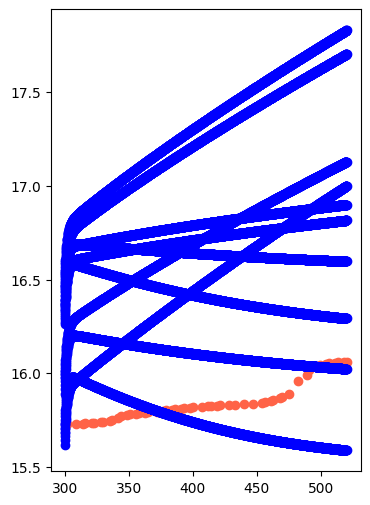

In [16]:
num_samples = 10
start_time = 300
end_time = 520 # sample from 06/27/2021 (DAY 0) through the end of the forecast 02/02/2022 (DAY 520)
num_timepoints = (end_time-start_time)*10 + 1

timepoints = list(get_tspan(start_time, end_time, num_timepoints).detach().numpy())

prior_samples = load_and_sample_petri_model(SEIVCDU,
    num_samples, timepoints=timepoints, method="euler",
                                            visual_options={"title": "3_base", "keep":["I_sol", "E_sol", "V_sol"]}, 
                                            time_unit="days")

# # Plot prior samples
# schema = plots.trajectories(pd.DataFrame(prior_samples["data"]), keep="V_sol",
#                             points=ww_data_train.reset_index(drop=True).rename(columns={"V":"V_data"}))
# schema = plots.pad(schema, 5)
# plots.ipy_display(schema)

# Plot cumulative viral load data and prior samples
plt.figure(figsize=(4,6))
plt.scatter(test_data.index, np.log10(test_data.V), color='tomato')
plt.scatter(prior_samples["data"]["timepoint_days"], np.log10(prior_samples["data"]["V_sol"]), color="blue")

### Plot all other priors

In [17]:
# schema = plots.trajectories(prior_samples["data"], keep=['S_sol', 'I_sol','C_sol', 'U_sol', 'D_sol'],
#                            # points=ww_data_train.reset_index(drop=True).rename(columns={"V":"V_data"})
#                            )
schema = plots.trajectories(prior_samples["data"], keep=['I_sol','C_sol', 'U_sol', 'D_sol'],
                           # points=ww_data_train.reset_index(drop=True).rename(columns={"V":"V_data"})
                           )
schema = plots.pad(schema, 5)
plots.ipy_display(schema)

### Plot posterior viral load against measured viral load

/Users/altu809/Projects/pyciemss/src/pyciemss/PetriNetODE/interfaces.py:864: UserWarning: Observation ObservationEvent(time=302.0, observation={'V': tensor(5.3421e+15)}) is not in the range [0, 598638313078784.0]. This may be an error!
  warnings.warn(f"Observation {obs} is not in the range [0, {petri.total_population}]. This may be an error!")
/Users/altu809/Projects/pyciemss/src/pyciemss/PetriNetODE/interfaces.py:864: UserWarning: Observation ObservationEvent(time=309.0, observation={'V': tensor(5.3627e+15)}) is not in the range [0, 598638313078784.0]. This may be an error!
  warnings.warn(f"Observation {obs} is not in the range [0, {petri.total_population}]. This may be an error!")
/Users/altu809/Projects/pyciemss/src/pyciemss/PetriNetODE/interfaces.py:864: UserWarning: Observation ObservationEvent(time=314.0, observation={'V': tensor(5.3811e+15)}) is not in the range [0, 598638313078784.0]. This may be an error!
  warnings.warn(f"Observation {obs} is not in the range [0, {petri.tot

iteration 0: loss = 80873091.27712965
iteration 25: loss = 19640482.279481173
iteration 50: loss = 2716105.9101474285
iteration 75: loss = 1979.5456895828247


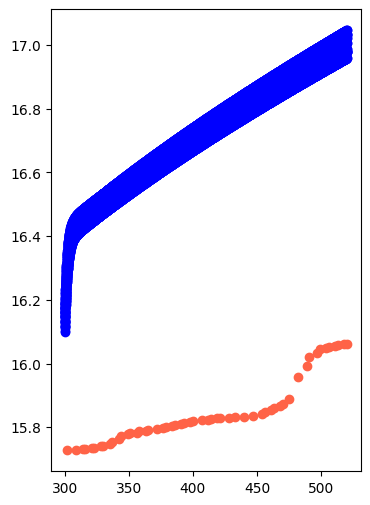

In [19]:
post_samples = load_and_calibrate_and_sample_petri_model(
    SEIVCDU,
    "../../notebook/ensemble_eval_sa/datasets/nys_ww_data.csv",
    num_samples,
    num_iterations=100,
    timepoints=timepoints,
    verbose=True,
    noise_scale=1.,
    method="euler", time_unit="days")

# # Plot results
# schema = plots.trajectories(pd.DataFrame(post_samples["data"]), keep="V_sol",
#                             points=ww_data_train.reset_index(drop=True).rename(columns={"V":"V_data"}))
# schema = plots.pad(schema, 5)
# plots.ipy_display(schema)

# Plot calibrated samples with data
plt.figure(figsize=(4,6))
plt.scatter(test_data.index, np.log10(test_data.V), color='tomato')
plt.scatter(post_samples["data"]["timepoint_days"], np.log10(post_samples["data"]["V_sol"]), color="blue")

### Plot posteriors of other variables

In [20]:
post_samples["data"]

timepoint_id  sample_id  lambda_param   k_param  alpha_param   
0                 0          0      0.131354  0.305516   326.628235  \
1                 1          0      0.131354  0.305516   326.628235   
2                 2          0      0.131354  0.305516   326.628235   
3                 3          0      0.131354  0.305516   326.628235   
4                 4          0      0.131354  0.305516   326.628235   
...             ...        ...           ...       ...          ...   
22005          2196          9      0.131848  0.299546   291.560913   
22006          2197          9      0.131848  0.299546   291.560913   
22007          2198          9      0.131848  0.299546   291.560913   
22008          2199          9      0.131848  0.299546   291.560913   
22009          2200          9      0.131848  0.299546   291.560913   

       gamma_param  delta_param  beta_param         C_sol          D_sol   
0         0.083669        0.125  44852600.0  1.319863e+05   40323.972656  \
1         0.083669        0.125  44852600.0  1.375990e+05   42038.742188   
2         0.083669        0.125  44852600.0  1.429762e+05   43681.582031   
3         0.083669        0.125  44852600.0  1.481267e+05   45255.140625   
4         0.083669        0.125  44852600.0  1.530634e+05   46763.394531   
...            ...          ...         ...           ...            ...   
22005     0.083571        0.125  44852600.0  1.039410e+06  311351.125000   
22006     0.083571        0.125  44852600.0  1.039974e+06  311520.156250   
22007     0.083571        0.125  44852600.0  1.040538e+06  311689.156250   
22008     0.083571        0.125  44852600.0  1.041103e+06  311858.312500   
22009     0.083571        0.125  44852600.0  1.041667e+06  312027.437500   

               E_sol          I_sol       S_sol          U_sol         V_sol   
0     -411943.250000  427618.031250  19198662.0   91662.312500  1.409415e+16  \
1     -393744.250000  409686.156250  19193050.0   95560.234375  1.466823e+16   
2     -376336.718750  392534.500000  19187672.0   99294.648438  1.521825e+16   
3     -359691.343750  376134.125000  19182522.0  102871.578125  1.574507e+16   
4     -343764.781250  360442.343750  19177586.0  106300.062500  1.625004e+16   
...              ...            ...         ...            ...           ...   
22005   18553.216797   42923.289062  18291238.0  728059.687500  9.525481e+16   
22006   18561.503906   42942.507812  18290674.0  728454.937500  9.530627e+16   
22007   18569.789062   42961.722656  18290110.0  728850.125000  9.535772e+16   
22008   18578.082031   42980.957031  18289546.0  729245.687500  9.540923e+16   
22009   18586.375000   43000.187500  18288982.0  729641.187500  9.546072e+16   

        logV_obs  timepoint_days  
0      16.149039      300.000000  
1      16.166378      300.100006  
2      16.182365      300.200012  
3      16.197145      300.299988  
4      16.210855      300.399994  
...          ...             ...  
22005  16.978887      519.599976  
22006  16.979122      519.700012  
22007  16.979356      519.799988  
22008  16.979591      519.900024  
22009  16.979825      520.000000  

[22010 rows x 17 columns]

In [21]:
schema = plots.trajectories(post_samples["data"], keep=['S_sol','I_sol','C_sol', 'U_sol', 'D_sol'],
                           # points=ww_data_train.reset_index(drop=True).rename(columns={"V":"V_data"})
                           )
schema = plots.pad(schema, 5)
plots.ipy_display(schema)

## SEIRHDS_ww model

In [12]:
from mira.sources.askenet import model_from_json_file
c = {
    'V': Concept(name='V', units=person_units(), identifiers={'vido': '0001331'}),
    'I': Concept(name='I', units=person_units(), identifiers={'ido': '0000511'}),
}
SEIRHDS_ww = model_from_json_file("operative_models/SEIRHDS_ww.json")
a_ww, b_ww, g_ww, I = sympy.symbols('a_ww b_ww g_ww I')
t4 = ControlledProduction(outcome=c['V'],
                          controller=c['I'],
                          rate_law=a_ww*b_ww*(1-g_ww)*I)
SEIRHDS_ww.templates.append(t4)
SEIRHDS_ww.observables = {}
SEIRHDS_ww.initials['V'] = Initial(concept=Concept(name='V'), value=5)
SEIRHDS_ww.parameters['g_ww'].distribution=Distribution(type='Uniform1', parameters={'minimum': 0.2, 'maximum': 0.6})
SEIRHDS_ww.parameters['beta'].distribution=Distribution(type='Uniform1', parameters={'minimum': 0.3, 'maximum': 0.55})

### Plot prior viral load against measured viral load

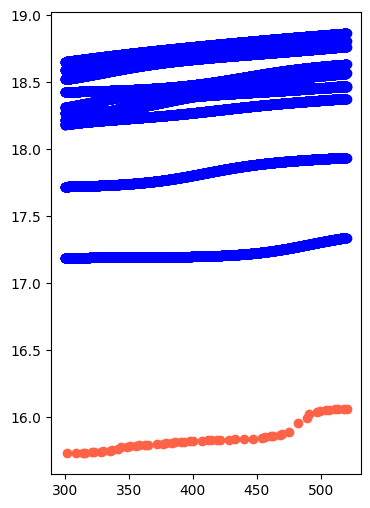

In [23]:
num_samples = 10
start_time = 300
end_time = 520 #226 # between 10/02/2020 and 01/25/2021
num_timepoints = (end_time-start_time)*10 + 1
timepoints = list(get_tspan(start_time, end_time, num_timepoints).detach().numpy())

prior_samples = load_and_sample_petri_model( SEIRHDS_ww,
    num_samples, timepoints=timepoints, method="dopri5",
                                            visual_options={"title": "3_base", "keep":["I_sol", "E_sol", "V_sol"]}, 
                                            time_unit="days")

# # Plot results
# schema = plots.trajectories(prior_samples["data"], keep="V_sol",
#                             points=ww_data_train.reset_index(drop=True).rename(columns={"V":"V_data"}))
# schema = plots.pad(schema, 5)
# plots.ipy_display(schema)

# Plot cumulative viral load data and prior samples
plt.figure(figsize=(4,6))
plt.scatter(test_data.index, np.log10(test_data.V), color='tomato')
plt.scatter(prior_samples["data"]["timepoint_days"], np.log10(prior_samples["data"]["V_sol"]), color="blue")

In [24]:
schema = plots.trajectories(prior_samples["data"].drop(columns=['V_sol']), keep=".*_sol",
                            #points=ww_data_train.reset_index(drop=True).rename(columns={"V":"V_data"})
                           )
schema = plots.pad(schema, 5)
plots.ipy_display(schema)

### Plot posterior viral load against measured viral load

/Users/altu809/Projects/pyciemss/src/pyciemss/PetriNetODE/interfaces.py:864: UserWarning: Observation ObservationEvent(time=302.0, observation={'V': tensor(5.3421e+15)}) is not in the range [0, 19340004.0]. This may be an error!
  warnings.warn(f"Observation {obs} is not in the range [0, {petri.total_population}]. This may be an error!")
/Users/altu809/Projects/pyciemss/src/pyciemss/PetriNetODE/interfaces.py:864: UserWarning: Observation ObservationEvent(time=309.0, observation={'V': tensor(5.3627e+15)}) is not in the range [0, 19340004.0]. This may be an error!
  warnings.warn(f"Observation {obs} is not in the range [0, {petri.total_population}]. This may be an error!")
/Users/altu809/Projects/pyciemss/src/pyciemss/PetriNetODE/interfaces.py:864: UserWarning: Observation ObservationEvent(time=314.0, observation={'V': tensor(5.3811e+15)}) is not in the range [0, 19340004.0]. This may be an error!
  warnings.warn(f"Observation {obs} is not in the range [0, {petri.total_population}]. This

iteration 0: loss = 498340.0993323326
iteration 25: loss = 133921.168484807
iteration 50: loss = 81264.80548286438
iteration 75: loss = 69082.36166834831
iteration 100: loss = 55661.312284469604
iteration 125: loss = 50514.12825334072
iteration 150: loss = inf
iteration 175: loss = 44577.67665660381
iteration 200: loss = inf
iteration 225: loss = 37249.102607011795
iteration 250: loss = 35795.14482104778
iteration 275: loss = inf


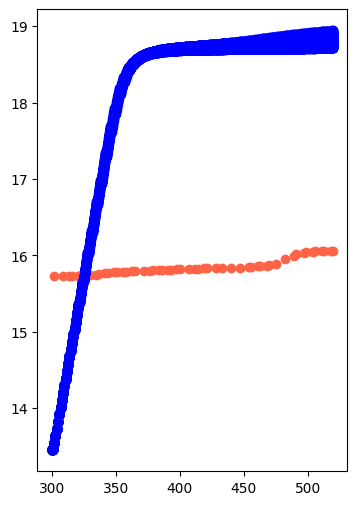

In [17]:
num_samples = 100
post_samples = load_and_calibrate_and_sample_petri_model(
    SEIRHDS_ww,
    '../../notebook/ensemble_eval_sa/datasets/nys_ww_data.csv',
    num_samples,
    num_iterations=300,
    timepoints=timepoints,
    verbose=True,
    noise_scale=1.,
    method="euler", time_unit="days")

post_samples["data"].to_csv("../../notebook/ensemble_eval_sa/ensemble_results/partIII_ensemble_of_one_results.csv", index=False)
post_samples["quantiles"].to_csv("../../notebook/ensemble_eval_sa/ensemble_results/partIII_ensemble_of_one_quantiles.csv", index=False)

q_ensemble_data = cdc_reformatcsv(filename="../../notebook/ensemble_eval_sa/ensemble_results/partIII_ensemble_of_one_quantiles.csv", 
                                  solution_string_mapping={"S": "susceptible", "I": "cases", "E": "exposed", "V": "cumulative viral load"}, 
                                  forecast_start_date="2022-01-03",
                                  location="New York State",
                                  drop_column_names=["timepoint_id", "number_days", "inc_cum", "output", "Forecast_Backcast"])
q_ensemble_data.to_csv("../../notebook/ensemble_eval_sa/ensemble_results/partIII_ensemble_of_one_forecast_quantiles_Jan042022.csv")

# # Plot results
# schema = plots.trajectories(post_samples["data"], keep="V_sol",
#                             points=ww_data_train.reset_index(drop=True).rename(columns={"V":"V_data"}))
# schema = plots.pad(schema, 5)
# plots.ipy_display(schema)

# Plot cumulative viral load data and prior samples
plt.figure(figsize=(4,6))
plt.scatter(test_data.index, np.log10(test_data.V), color='tomato')
plt.scatter(post_samples["data"]["timepoint_days"], np.log10(post_samples["data"]["V_sol"]), color="blue")

In [18]:
schema = plots.trajectories(post_samples["data"].drop(columns=['V_sol']), keep=".*_sol",
                            #points=ww_data_train.reset_index(drop=True).rename(columns={"V":"V_data"})
                           )
schema = plots.pad(schema, 5)
plots.ipy_display(schema)

# Calibrate ensemble

In [19]:
num_samples = 2
model_paths = [SEIV, SEIVCDU, SEIRHDS_ww]
data_path = "../../notebook/ensemble_eval_sa/datasets/nys_ww_data.csv"
weights = [0.1, 0.2, 0.7]
seiv= dict(S='S', I='I', E='E', V='V')
solution_mappings = [seiv,seiv, seiv]
prior_ensemble = load_and_sample_petri_ensemble(model_paths,
                                                weights,
                                                solution_mappings,
                                                num_samples,
                                                timepoints,
                                                time_unit="days")

### Plot ensemble priors

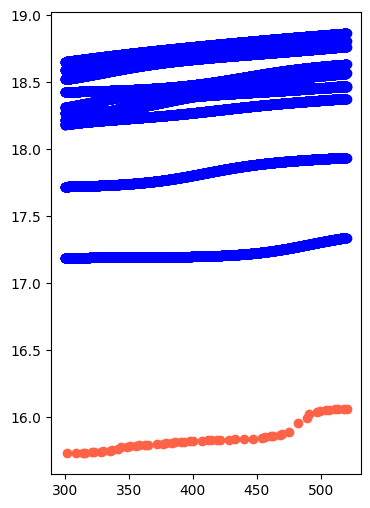

In [28]:
# schema = plots.trajectories(prior_ensemble["data"], keep="V_sol",
#                             points=ww_data_train.reset_index(drop=True).rename(columns={"V":"V_data"}),
#                            )
# schema = plots.pad(schema, 5)
# plots.ipy_display(schema)     

# Plot cumulative viral load data and prior samples
plt.figure(figsize=(4,6))
plt.scatter(test_data.index, np.log10(test_data.V), color='tomato')
plt.scatter(prior_samples["data"]["timepoint_days"], np.log10(prior_samples["data"]["V_sol"]), color="blue")

In [29]:
schema = plots.trajectories(prior_ensemble["data"].drop(columns=['V_sol']), keep=".*_sol",
                            #points=ww_data_train.reset_index(drop=True).rename(columns={"V":"V_data"})
                           )
schema = plots.pad(schema, 5)
plots.ipy_display(schema)          

### Run the calibration and sampling

In [21]:
# Run the calibration and sampling
num_samples = 100
post_ensemble = load_and_calibrate_and_sample_ensemble_model(
    model_paths,
    data_path,
    weights,
    solution_mappings,
    num_samples,
    timepoints,
    verbose=True,
    num_iterations=150,
    time_unit="days",
    visual_options={"title": "Calibrated Ensemble", "keep":".*_sol"}
)

# Save results
post_ensemble["data"].to_csv("../../notebook/ensemble_eval_sa/ensemble_results/partIII_ensemble_of_many_results.csv", index=False)
post_ensemble["quantiles"].to_csv("../../notebook/ensemble_eval_sa/ensemble_results/partIII_ensemble_of_many_quantiles.csv", index=False)

q_ensemble_data = cdc_reformatcsv(filename="../../notebook/ensemble_eval_sa/ensemble_results/partIII_ensemble_of_many_quantiles.csv", 
                                  solution_string_mapping={"S": "susceptible", "I": "cases", "E": "exposed", "V": "cumulative viral load"}, 
                                  forecast_start_date="2022-01-03",
                                  location="New York State",
                                  drop_column_names=["timepoint_id", "number_days", "inc_cum", "output", "Forecast_Backcast"])
q_ensemble_data.to_csv("../../notebook/ensemble_eval_sa/ensemble_results/partIII_ensemble_of_many_forecast_quantiles_Jan042022.csv")

iteration 0: loss = 4106.044204249978
iteration 25: loss = 3998.7693609148264
iteration 50: loss = 3815.9691234976053
iteration 75: loss = 3066.930680528283
iteration 100: loss = inf
iteration 125: loss = 1673.395966425538


### Save results and compare predicting and observed viral loads

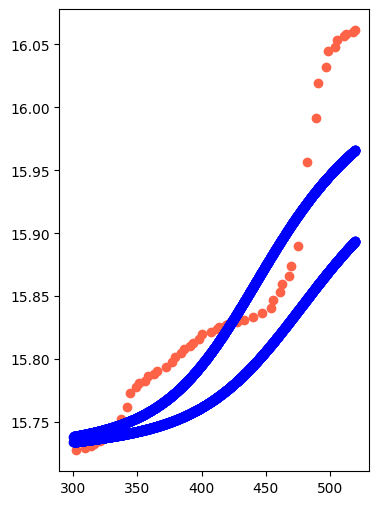

In [31]:
# Plot cumulative viral load data and prior samples
plt.figure(figsize=(4,6))
plt.scatter(test_data.index, np.log10(test_data.V), color='tomato')
plt.scatter(post_ensemble["data"]["timepoint_days"], np.log10(post_ensemble["data"]["V_sol"]), color="blue")

### Plot posteriors of other variables

In [32]:
schema = plots.trajectories(post_ensemble["data"].drop(columns=['V_sol']), keep=".*_sol",
                            # points=test_data.reset_index(drop=True).rename(columns={"V":"V_data"}),
                           )
schema = plots.pad(schema, 5)
plots.ipy_display(schema)

# (1) Forecast 1: 01/04/2022 - 02/01/2022

## (A) Calibrate and sample an ensemble of one model

### Post-process and save results

In [ ]:
RESULTS_FILENAME = RESULTS_PATH + "T3_ensemble_of1_results_Jan042022.csv"
QUANTILES_FILENAME = RESULTS_PATH + "T3_ensemble_of1_quantiles_Jan042022.csv"

## (B) Calibrate and sample an ensemble of multiple models

### Post-process and save results

In [ ]:
RESULTS_FILENAME = RESULTS_PATH + "T3_ensemble_of3_results_Jan042022.csv"
QUANTILES_FILENAME = RESULTS_PATH + "T3_ensemble_of3_quantiles_Jan042022.csv"

# (2) Forecast 2: 01/11/2022 - 02/08/2022

## (A) Calibrate and sample an ensemble of one model

### Post-process and save results

In [ ]:
RESULTS_FILENAME = RESULTS_PATH + "T3_ensemble_of1_results_Jan112022.csv"
QUANTILES_FILENAME = RESULTS_PATH + "T3_ensemble_of1_quantiles_Jan112022.csv"

## (B) Calibrate and sample an ensemble of multiple models

### Post-process and save results

In [ ]:
RESULTS_FILENAME = RESULTS_PATH + "T3_ensemble_of3_results_Jan112022.csv"
QUANTILES_FILENAME = RESULTS_PATH + "T3_ensemble_of3_quantiles_Jan112022.csv"

# (3) Forecast 3: 01/18/2022 - 02/15/2022

## (A) Calibrate and sample an ensemble of one model

### Post-process and save results

In [ ]:
RESULTS_FILENAME = RESULTS_PATH + "T3_ensemble_of1_results_Jan182022.csv"
QUANTILES_FILENAME = RESULTS_PATH + "T3_ensemble_of1_quantiles_Jan182022.csv"

## (B) Calibrate and sample an ensemble of multiple models

### Post-process and save results

In [ ]:
RESULTS_FILENAME = RESULTS_PATH + "T3_ensemble_of3_results_Jan182022.csv"
QUANTILES_FILENAME = RESULTS_PATH + "T3_ensemble_of3_quantiles_Jan182022.csv"

# (4) Forecast 4: 01/25/2022 - 02/22/2022

## (A) Calibrate and sample an ensemble of one model

### Post-process and save results

In [ ]:
RESULTS_FILENAME = RESULTS_PATH + "T3_ensemble_of3_results_Jan252022.csv"
QUANTILES_FILENAME = RESULTS_PATH + "T3_ensemble_of3_quantiles_Jan252022.csv"

## (B) Calibrate and sample an ensemble of multiple models

### Post-process and save results

In [ ]:
RESULTS_FILENAME = RESULTS_PATH + "T3_ensemble_of3_results_Jan252022.csv"
QUANTILES_FILENAME = RESULTS_PATH + "T3_ensemble_of3_quantiles_Jan252022.csv"